## 1. Introduction

LendingClub is a US peer-to-peer lending company and the world's largest peer-to-peer lending platform. As explained by Wikipedia,

Lending Club enables borrowers to create unsecured personal loans between $1,000  and  $40,000. The standard loan period is three years. Investors can search and browse the loan listings on Lending Club website and select loans that they want to invest in based on the information supplied about the borrower, amount of loan, loan grade, and loan purpose. Investors make money from interest. Lending Club makes money by charging borrowers an origination fee and investors a service fee.

The goal of this project is to build a machine learning model to predict the probability that a loan will charge off. We will attempt to only use data available to investors via the LendingClub loan listing, including information about the borrower (income, employment length, FICO score, debt-to-income ratio, etc.) and the loan listing (the loan amount, loan purpose, loan grade, interest rate, installment, etc.). Such a predictive model could help LendingClub investors make better-informed investment decisions. We will only consider loans that LendingClub accepted under its credit underwriting policy.

## 1.1 References

LendingClub information
https://www.lendingclub.com
    
Datasets
The dataset used in this project, hosted on Kaggle
https://www.kaggle.com/wordsforthewise/lending-club

## 2. Import the data

In [142]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from scipy import stats
import statistics
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_squared_error, make_scorer
import seaborn as sns
import plotly.graph_objects as go
import re
import os
from scipy.stats import skew, probplot, norm
import sklearn.model_selection as ms
from sklearn.ensemble import RandomForestRegressor
from pprint import pprint
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV, LassoCV, Lasso, ElasticNet 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold 
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from xgboost import XGBRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [ ]:
# load data
loans = pd.read_csv('/Users/Muyan/Desktop/accepted_2007_to_2018Q4.csv', low_memory=False)

In [55]:
loans.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Columns: 151 entries, id to settlement_term
dtypes: float64(113), object(38)
memory usage: 2.5+ GB


## 3. Responsible variable

In [57]:
loans['loan_status'].value_counts(dropna=False)

Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
NaN                                                         33
Name: loan_status, dtype: int64

We're going to try to learn differences in the features between completed loans that have been fully paid or charged off. We won't consider loans that are current, don't meet the credit policy, defaulted, or have a missing status. So we only keep the loans with status "Fully Paid" or "Charged Off."

In [58]:
loans = loans.loc[loans['loan_status'].isin(['Fully Paid', 'Charged Off'])]

How many loans remain in the dataset?

In [59]:
loans.shape

(1345310, 151)

There are 814,986 loans remaining. Check that the statuses are as expected:

In [60]:
loans['loan_status'].value_counts(dropna=False)

Fully Paid     1076751
Charged Off     268559
Name: loan_status, dtype: int64

Status counts as percentages:

In [61]:
loans['loan_status'].value_counts(normalize=True, dropna=False)

Fully Paid     0.800374
Charged Off    0.199626
Name: loan_status, dtype: float64


About 79% of the remaining loans have been fully paid and 21% have charged off, so we have a somewhat unbalanced classification problem.

## 4. Limited the feature space

The full dataset has 150 features for each loan. We will select features in two steps:

1. Drop features with more than 30% of their data missing.
2. Of the remaining features, choose only those that would be available to an investor before deciding to fund the loan.

Definitions of the features are given in the LendingClub Data Dictionary: https://www.lendingclub.com/auth/login?login_url=%2Finfo%2Fdownload-data.action

## 4.1 Drop features missing more than 30% data

In [62]:
missing_fractions = loans.isnull().mean().sort_values(ascending=False)

In [63]:
missing_fractions.head(10)

member_id                                     1.000000
next_pymnt_d                                  1.000000
orig_projected_additional_accrued_interest    0.997206
hardship_start_date                           0.995723
hardship_end_date                             0.995723
payment_plan_start_date                       0.995723
hardship_length                               0.995723
hardship_dpd                                  0.995723
hardship_loan_status                          0.995723
hardship_last_payment_amount                  0.995723
dtype: float64

Let's visualize the distribution of missing data percentages:

Text(0, 0.5, 'Feature count')

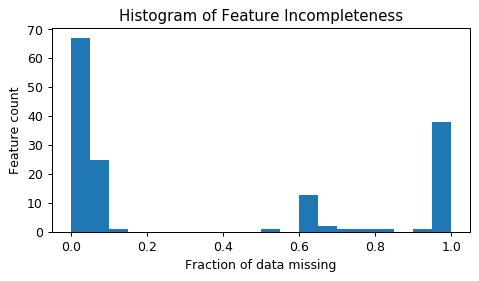

In [64]:
plt.figure(figsize=(6,3), dpi=90)
missing_fractions.plot.hist(bins=20)
plt.title('Histogram of Feature Incompleteness')
plt.xlabel('Fraction of data missing')
plt.ylabel('Feature count')

From the above histogram, we see there's a large gap between features missing "some" data (<20%) and those missing "lots" of data (>40%). Because it's generally very difficult to accurately impute data with more than 30% missing values, we drop such columns. First store all variables missing more than 30% data in an alphabetical list:

In [65]:
drop_list = sorted(list(missing_fractions[missing_fractions > 0.3].index))
print(drop_list)

['all_util', 'annual_inc_joint', 'debt_settlement_flag_date', 'deferral_term', 'desc', 'dti_joint', 'hardship_amount', 'hardship_dpd', 'hardship_end_date', 'hardship_last_payment_amount', 'hardship_length', 'hardship_loan_status', 'hardship_payoff_balance_amount', 'hardship_reason', 'hardship_start_date', 'hardship_status', 'hardship_type', 'il_util', 'inq_fi', 'inq_last_12m', 'max_bal_bc', 'member_id', 'mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_last_record', 'mths_since_rcnt_il', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq', 'next_pymnt_d', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'open_rv_12m', 'open_rv_24m', 'orig_projected_additional_accrued_interest', 'payment_plan_start_date', 'revol_bal_joint', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_earliest_cr_line', 'sec_app_fico_range_high', 'sec_app_fico_range_low', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_mths_since_last_ma

In [66]:
len(drop_list)

58

In [67]:
loans.drop(labels=drop_list, axis=1, inplace=True)

In [68]:
loans.shape

(1345310, 93)

## 4.2 Features Engineering

We will inspect each feature individually, and do the following:
1. Drop the feature if it is not useful for predicting the loan status.
2. View summary statistics and visualize the data, plotting against the loan status.
3. Modify the feature to make it useful for modeling, if necessary.

In [69]:
print(sorted(loans.columns))

['acc_now_delinq', 'acc_open_past_24mths', 'addr_state', 'annual_inc', 'application_type', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'debt_settlement_flag', 'delinq_2yrs', 'delinq_amnt', 'disbursement_method', 'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low', 'funded_amnt', 'funded_amnt_inv', 'grade', 'hardship_flag', 'home_ownership', 'id', 'initial_list_status', 'inq_last_6mths', 'installment', 'int_rate', 'issue_d', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'last_pymnt_amnt', 'last_pymnt_d', 'loan_amnt', 'loan_status', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sa

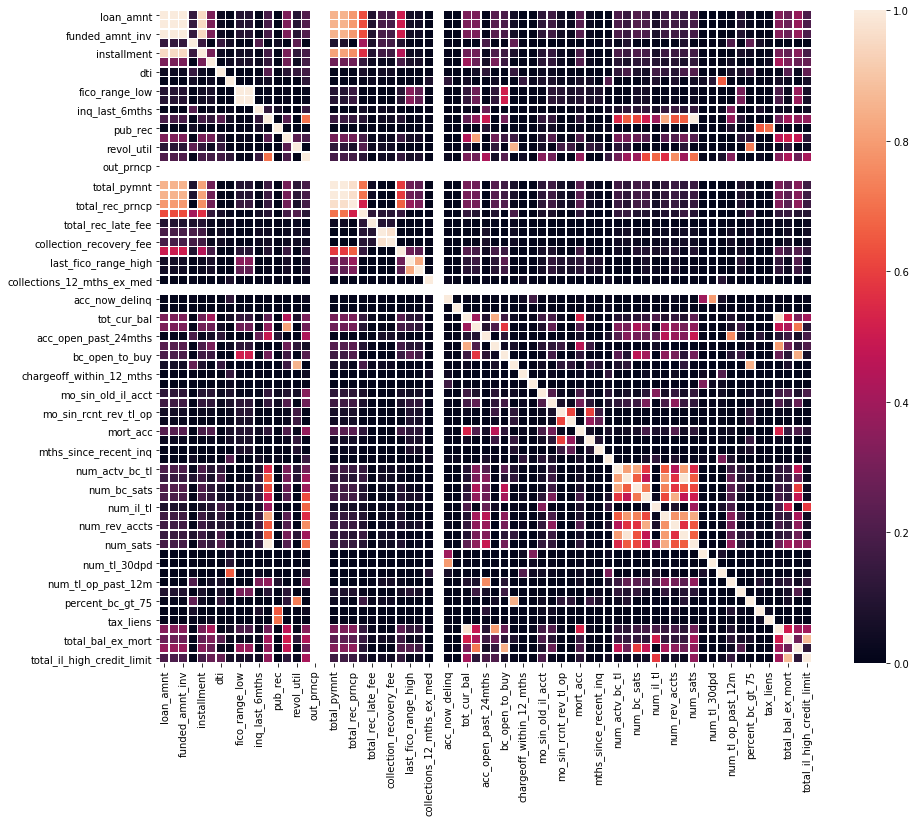

In [70]:
corrmat = loans.corr()
f, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(corrmat,linewidths=.5,vmin=0, vmax=1, square=True)

In [71]:
# Drop off Multicollinear Features
drop_cols = ['out_prncp', 'out_prncp_inv', 'total_pymnt_inv', 'total_rec_prncp', 'funded_amnt',
             'funded_amnt_inv', 'num_actv_rev_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0']

print("Drop off Multicollinear Features: " + str(len(drop_cols)))
print(drop_cols)

loans = loans.drop(drop_cols, axis=1)

Drop off Multicollinear Features: 11
['out_prncp', 'out_prncp_inv', 'total_pymnt_inv', 'total_rec_prncp', 'funded_amnt', 'funded_amnt_inv', 'num_actv_rev_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0']


In [72]:
loans.shape

(1345310, 82)

In [73]:
loans.head()

,id,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,...,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,68407277,3600.0,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,...,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,N,Cash,N
1,68355089,24700.0,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,...,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,N,Cash,N
2,68341763,20000.0,60 months,10.78,432.66,B,B4,truck driver,10+ years,MORTGAGE,...,50.0,0.0,0.0,218418.0,18696.0,6200.0,14877.0,N,Cash,N
4,68476807,10400.0,60 months,22.45,289.91,F,F1,Contract Specialist,3 years,MORTGAGE,...,60.0,0.0,0.0,439570.0,95768.0,20300.0,88097.0,N,Cash,N
5,68426831,11950.0,36 months,13.44,405.18,C,C3,Veterinary Tecnician,4 years,RENT,...,100.0,0.0,0.0,16900.0,12798.0,9400.0,4000.0,N,Cash,N


In [74]:
loans

,id,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,...,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,68407277,3600.0,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,...,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,N,Cash,N
1,68355089,24700.0,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,...,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,N,Cash,N
2,68341763,20000.0,60 months,10.78,432.66,B,B4,truck driver,10+ years,MORTGAGE,...,50.0,0.0,0.0,218418.0,18696.0,6200.0,14877.0,N,Cash,N
4,68476807,10400.0,60 months,22.45,289.91,F,F1,Contract Specialist,3 years,MORTGAGE,...,60.0,0.0,0.0,439570.0,95768.0,20300.0,88097.0,N,Cash,N
5,68426831,11950.0,36 months,13.44,405.18,C,C3,Veterinary Tecnician,4 years,RENT,...,100.0,0.0,0.0,16900.0,12798.0,9400.0,4000.0,N,Cash,N
6,68476668,20000.0,36 months,9.17,637.58,B,B2,Vice President of Recruiting Operations,10+ years,MORTGAGE,...,100.0,0.0,0.0,388852.0,116762.0,31500.0,46452.0,N,Cash,N
7,67275481,20000.0,36 months,8.49,631.26,B,B1,road driver,10+ years,MORTGAGE,...,0.0,0.0,0.0,193390.0,27937.0,14500.0,36144.0,N,Cash,N
8,68466926,10000.0,36 months,6.49,306.45,A,A2,SERVICE MANAGER,6 years,RENT,...,28.6,1.0,0.0,61099.0,27957.0,16400.0,30799.0,N,Cash,N
9,68616873,8000.0,36 months,11.48,263.74,B,B5,Vendor liaison,10+ years,MORTGAGE,...,33.3,0.0,0.0,256513.0,113782.0,17000.0,135513.0,N,Cash,N
12,68338832,1400.0,36 months,12.88,47.10,C,C2,Logistics Manager,3 years,MORTGAGE,...,75.0,0.0,0.0,372109.0,75258.0,34500.0,55501.0,N,Cash,N


In [83]:
loans['emp_title'].replace(np.NaN,'unknown').str.lower()

0                                          leadman
1                                         engineer
2                                     truck driver
4                              contract specialist
5                             veterinary tecnician
6          vice president of recruiting operations
7                                      road driver
8                                  service manager
9                                   vendor liaison
12                               logistics manager
13                                software manager
14                                  senior manager
15                                            tech
16                                   sales manager
17                                           gs-11
19                            program coordinator 
20                             corporate insurance
21                           bookkeeper/accounting
22                director of product development 
23                             

In [84]:
# drop useless column
loans = loans.drop(['id', 'url'], axis=1)

# convert date type (issue_d)
loans = loans.assign(issue_d=pd.to_datetime(loans['issue_d'], format='%b-%Y'))

# convert lower case
loans['emp_title'] = loans['emp_title'].replace(np.NaN,'unknown').str.lower()
loans['title'] = loans['title'].replace(np.NaN,'unknown').str.lower()
# imputation
loans['emp_length'].value_counts(dropna=False).sort_index()
loans['emp_length'].replace(to_replace='10+ years', value='10 years', inplace=True)
loans['emp_length'].replace('< 1 year', '0 years', inplace=True)
loans['emp_length'] = loans['emp_length'].replace(np.NaN, '0') # minimum new value

# imputation (1 record)
loans['zip_code'] = loans['zip_code'].replace(np.NaN, '00000') 
loans['inq_last_6mths'] = loans['inq_last_6mths'].replace(np.NaN, 0)

In [85]:
loans.emp_title.value_counts()

unknown                                         85785
teacher                                         25691
manager                                         24896
owner                                           15487
registered nurse                                12092
driver                                          11438
supervisor                                      11049
sales                                           10466
rn                                               9605
project manager                                  7488
office manager                                   7412
general manager                                  6894
truck driver                                     6034
director                                         5446
engineer                                         5088
president                                        4961
sales manager                                    4554
operations manager                               4232
police officer              

In [87]:
def emp_length_to_int(s):
    if pd.isnull(s):
        return s
    else:
        return int(s.split()[0])

In [88]:
loans['emp_length'] = loans['emp_length'].apply(emp_length_to_int)

In [89]:
loans['emp_length'].value_counts(dropna=False).sort_index()

0     186572
1      88494
2     121743
3     107597
4      80556
5      84154
6      62733
7      59624
8      60701
9      50937
10    442199
Name: emp_length, dtype: int64

In [90]:
numeric_columns = ['loan_amnt','installment','int_rate','annual_inc','dti']

loans[numeric_columns] = loans[numeric_columns].apply(pd.to_numeric)

In [95]:
# imputation (IterativeImputer)
target_col = []
drop_cols = []

col_null_cnt = loans.isnull().sum()
for k, v in col_null_cnt.iteritems():
    if v > 0:
        if loans[k].dtype == 'float64':
            target_col = target_col + [k]
        else:
            drop_cols = drop_cols + [k]

loans = loans.drop(drop_cols, axis=1) # drop non numeric column
print('drop non numeric column (date): ' + str(len(drop_cols)))
print(drop_cols)
print()

print('target columns for imputation: ' + str(len(target_col)))
print(target_col)
print()

imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(loans[target_col])
print(imp)

imputed = imp.transform(loans[target_col])
loans[target_col] = imputed

drop non numeric column (date): 0
[]

target columns for imputation: 35
['dti', 'revol_util', 'collections_12_mths_ex_med', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_bc_sats', 'num_bc_tl', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tax_liens', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit']



TypeError: __init__() got an unexpected keyword argument 'njobs'

In [97]:
# save imputed dataframe
loans.to_csv('/Users/Muyan/Desktop/loans_clean.csv', index=False)

# 5. Data visualization

5.1 Grades

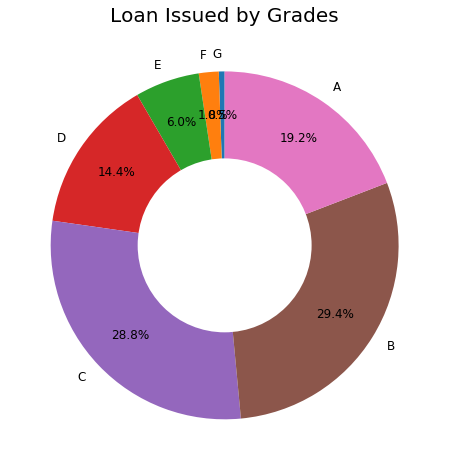

In [72]:
# Loan issued grouped by grades
loan_group = loans['grade'].value_counts()
loan_group_df = pd.DataFrame({'grade':loan_group.index, 'count':loan_group.values})
loan_group_df = loan_group_df.assign(ratio=loan_group_df['count'] / sum(loan_group_df['count']) * 100).sort_values(by='grade', ascending=False)

plt.figure(figsize=(8, 8))
plt.pie(loan_group_df['ratio'], labels=loan_group_df['grade'], autopct='%1.1f%%', startangle=90, pctdistance=0.75, textprops={'fontsize': 12})
plt.title('Loan Issued by Grades', size=20)

centre_circle = plt.Circle((0,0), 0.5, color='black', fc='white', linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.show()

5.2 FICO score

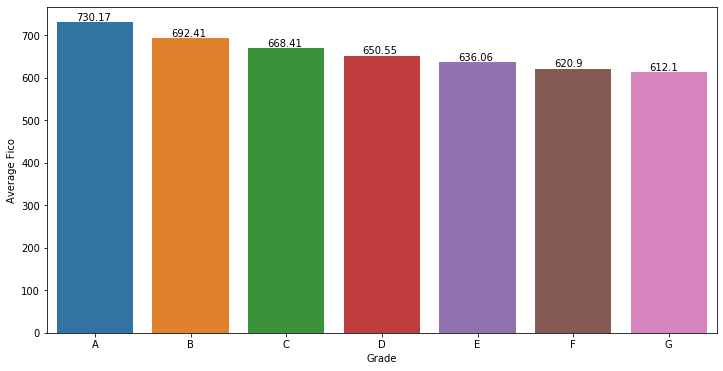

In [73]:
# analysis fico score for grade
fico_avg = (loans['last_fico_range_high'] + loans['last_fico_range_low']) / 2
grade_agg = loans.assign(fico_avg=fico_avg).groupby(['grade']).aggregate({'fico_avg':'mean'})
grade_agg = grade_agg.reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='grade', y='fico_avg', data=grade_agg)

plt.xlabel("Grade")
plt.ylabel("Average Fico")

for x, y in zip(range(0, 7), grade_agg['fico_avg']):
    plt.text(x - 0.2, y + 5, round(y, 2))

plt.show()

5.2.1 Ave FICO score with loan status

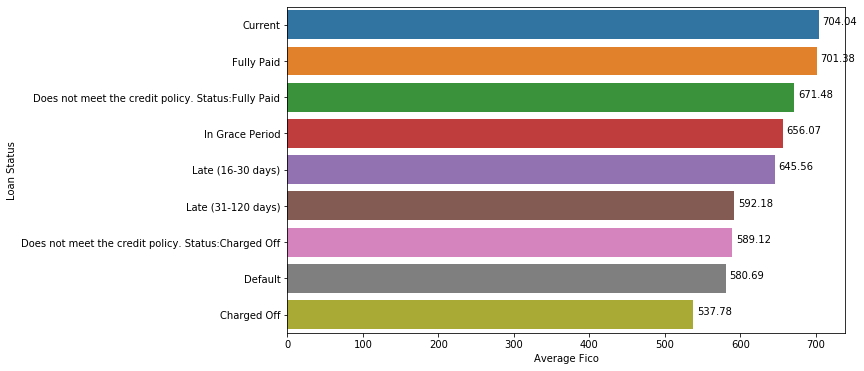

In [74]:
grade_agg = loans.assign(fico_avg=fico_avg).groupby(['loan_status']).aggregate({'fico_avg':'mean'})
grade_agg = grade_agg.reset_index().sort_values('fico_avg', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(y='loan_status', x='fico_avg', data=grade_agg)

plt.xlabel("Average Fico")
plt.ylabel("Loan Status")

for x, y in zip(range(0, 9), grade_agg['fico_avg']):
    plt.text(y + 5, x, round(y, 2))

plt.show()

5.3 Loan purpose

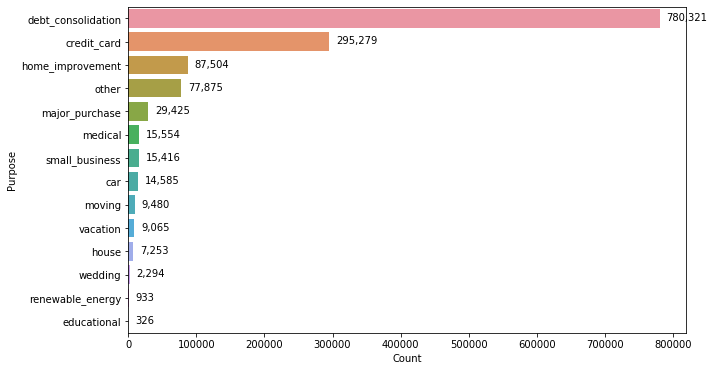

In [100]:
purpose_cnt = loans['purpose'].value_counts().rename_axis('purpose').to_frame('count').reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(y='purpose', x='count', data=purpose_cnt)

plt.xlabel("Count")
plt.ylabel("Purpose")

for x, y in zip(range(0, 14), purpose_cnt['count']):
    plt.text(y + 10000, x + 0.1, format(y, ',d'))

plt.show()

5.4 Loan status by fully paid and charged off

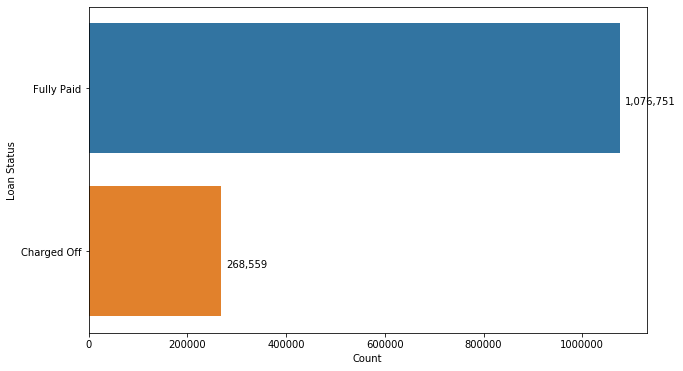

In [101]:
# imbalance (Fully Paid, Current)
status_cnt = loans['loan_status'].value_counts().rename_axis('status').to_frame('count').reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(y='status', x='count', data=status_cnt)

plt.xlabel("Count")
plt.ylabel("Loan Status")

for x, y in zip(range(0, 14), status_cnt['count']):
    plt.text(y + 10000, x + 0.1, format(y, ',d'))

plt.show()

In [104]:
# Charged-off loans tend to have higher loan amounts. Let's compare the summary statistics by loan status
loans.groupby('loan_status')['loan_amnt'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,268559.0,15565.055444,8814.560077,900.0,9000.0,14350.0,20400.0,40000.0
Fully Paid,1076751.0,14134.369808,8669.028973,500.0,7500.0,12000.0,20000.0,40000.0


In [105]:
# Loan status with term
# Data Dictionary: "The number of payments on the loan. Values are in months and can be either 36 or 60."
loans.groupby('term')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']

term
 36 months    0.159934
 60 months    0.324454
Name: loan_status, dtype: float64

About 75% of the completed loans have three-year periods, and the rest have five-year periods. Loans with five-year periods are more than twice as likely to charge-off as loans with three-year periods.

5.5 Total amount by states

In [143]:
state_total_amnt = loans.groupby(['addr_state']).aggregate({'loan_amnt':['sum']}).reset_index()
state_total_amnt.columns = ['state', 'total_loan']

fig = go.Figure(data=go.Choropleth(
    locations=state_total_amnt['state'],
    z = state_total_amnt['total_loan'],
    locationmode = 'USA-states',
    colorscale = 'Blues',
    colorbar_title = "Millions USD",
))

fig.update_layout(
    title_text = 'US Total Loan Amount',
    geo_scope='usa',
)

fig.show()

KeyError: 'addr_state'

5.6 Loan Issued by home ownership

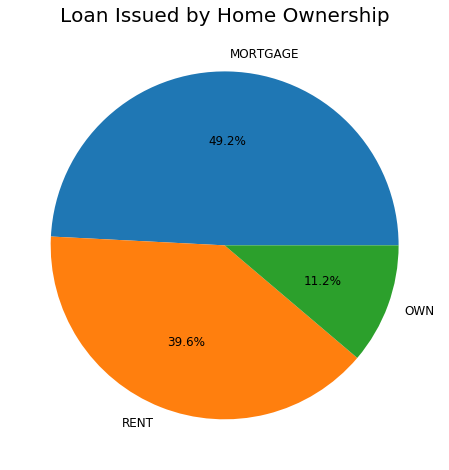

In [70]:
loan_home_ownership = loans['home_ownership'].value_counts()[:3]
loan_home_ownership_df = pd.DataFrame({'home_ownership':loan_home_ownership.index, 'count':loan_home_ownership.values})
loan_home_ownership_df = loan_home_ownership_df.assign(ratio=loan_home_ownership_df['count'] / sum(loan_home_ownership_df['count']) * 100)

plt.figure(figsize=(8, 8))
plt.pie(loan_home_ownership_df['ratio'], labels=loan_home_ownership_df['home_ownership'], autopct='%1.1f%%', startangle=0, textprops={'fontsize': 12})
plt.title('Loan Issued by Home Ownership', size=20)

plt.show()

5.6.1 Employee_Length

In [110]:
# default rate by employment length


5.6.2 DTI

Text(0.5, 1.0, 'Debt-to-income Ratio')

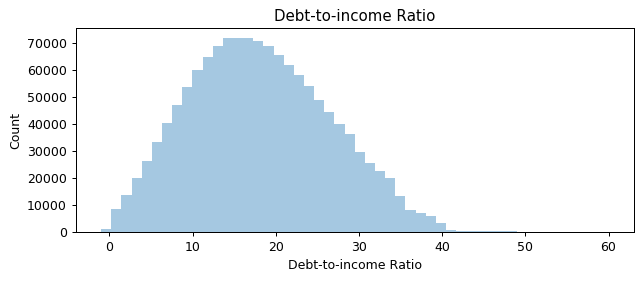

In [106]:
plt.figure(figsize=(8,3), dpi=90)
sns.distplot(loans.loc[loans['dti'].notnull() & (loans['dti']<60), 'dti'], kde=False)
plt.xlabel('Debt-to-income Ratio')
plt.ylabel('Count')
plt.title('Debt-to-income Ratio')

In [107]:
(loans['dti']>=60).sum()

1715

5.6.4 Income

5.6.5 Total account

Text(0.5, 1.0, 'Total Number of Credit Lines')

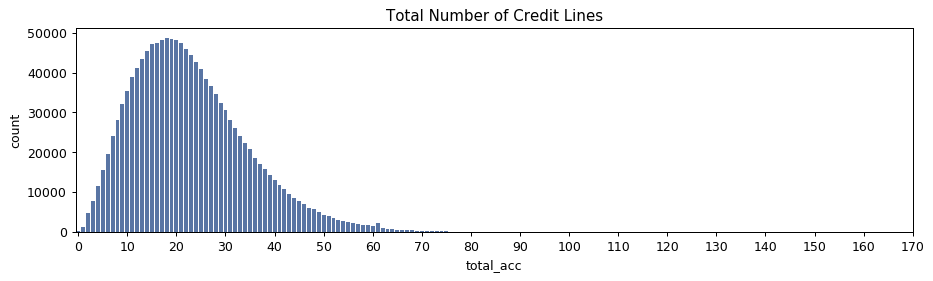

In [111]:
plt.figure(figsize=(12,3), dpi=90)
sns.countplot(loans['total_acc'], order=sorted(loans['total_acc'].unique()), color='#5975A4', saturation=1)
_, _ = plt.xticks(np.arange(0, 176, 10), np.arange(0, 176, 10))
plt.title('Total Number of Credit Lines')

In [112]:
# create new data set for Fully Paid and (Charged Off + Default)
loans_new = loans[(loans['loan_status'] == 'Fully Paid') | (loans['loan_status'] == 'Charged Off') | (loans['loan_status'] == 'Default')]
loans_new = loans_new.assign(paid_flag = np.where(loans_new['loan_status'].str.contains('Fully Paid'), 1, 0))

5.7 Default Rate by Grade

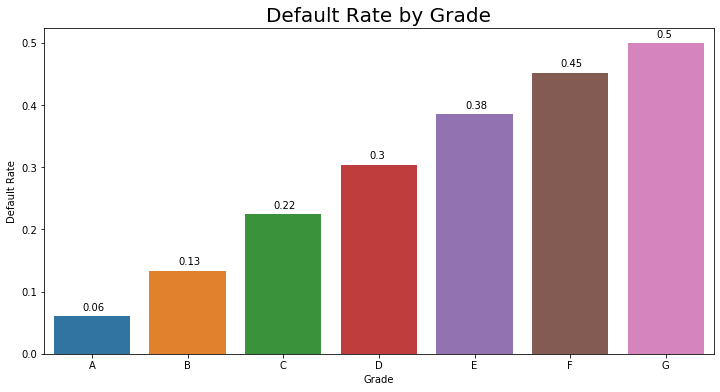

In [113]:
# default rate by grade
default_rate_grade = loans_new.groupby(['grade']).aggregate({'paid_flag':['sum', 'count']}).reset_index()
default_rate = (default_rate_grade['paid_flag']['count'] - default_rate_grade['paid_flag']['sum']) / default_rate_grade['paid_flag']['count']
default_rate_grade = default_rate_grade.assign(default_rate=default_rate)

plt.figure(figsize=(12, 6))
sns.barplot(x='grade', y='default_rate', data=default_rate_grade).set_title('Default Rate by Grade', fontsize=20)

plt.xlabel("Grade")
plt.ylabel("Default Rate")

for x, y in zip(range(0, 7), default_rate_grade['default_rate']):
    plt.text(x - 0.1, y + 0.01, round(y, 2))

plt.show()

5.7.1 Default Rate by Purpose

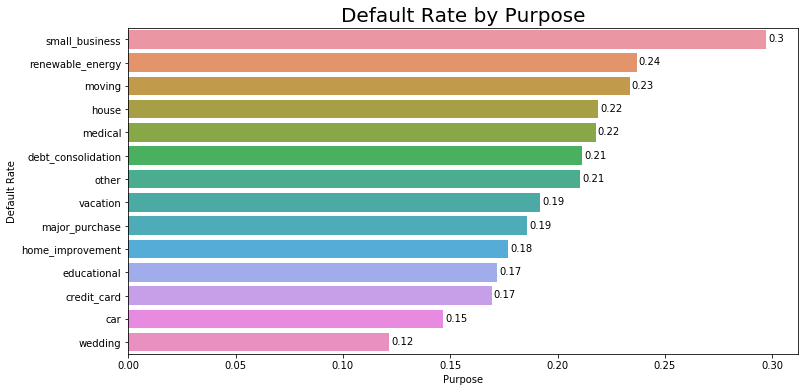

In [114]:
default_rate_purpose = loans_new.groupby(['purpose']).aggregate({'paid_flag':['sum', 'count']}).reset_index()
default_rate = (default_rate_purpose['paid_flag']['count'] - default_rate_purpose['paid_flag']['sum']) / default_rate_purpose['paid_flag']['count']
default_rate_purpose = default_rate_purpose.assign(default_rate=default_rate)
default_rate_purpose = default_rate_purpose.sort_values('default_rate', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='default_rate', y='purpose', data=default_rate_purpose).set_title('Default Rate by Purpose', fontsize=20)

plt.xlabel("Purpose")
plt.ylabel("Default Rate")

for x, y in zip(range(0, 14), default_rate_purpose['default_rate']):
    plt.text(y + 0.001, x + 0.1, round(y, 2))

plt.show()

5.7.2 Default Rate by Employment Length

## 6. Investment Return Analysis

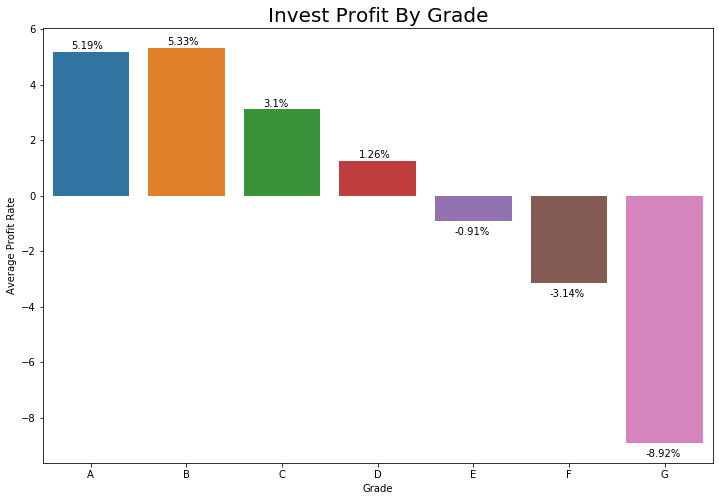

In [122]:
# invest profit by grade
profit_rate = (loans_new['total_pymnt'] - loans_new['loan_amnt']) / loans_new['loan_amnt'] * 100
grade_agg = loans_new.assign(profit_rate=profit_rate).groupby(['grade']).aggregate({'profit_rate':'mean'})
grade_agg = grade_agg.reset_index()

plt.figure(figsize=(12, 8))
sns.barplot(x='grade', y='profit_rate', data=grade_agg).set_title('Invest Profit By Grade', fontsize=20)

plt.xlabel("Grade")
plt.ylabel("Average Profit Rate")

for x, y in zip(range(0, 7), grade_agg['profit_rate']):
    if y < 0:
        plt.text(x - 0.2, y - 0.5, str(round(y, 2)) + '%')
    else:
        plt.text(x - 0.2, y + 0.1, str(round(y, 2)) + '%')

plt.show()

## 7. More Pre-processing

7.1 Convert loan status to 0/1 charge-off indicator

Change the response variable loan_status to a 0/1 variable, where 0 indicates fully paid and 1 indicates charge-off:

In [121]:
loans['charged_off'] = (loans['loan_status'] == 'Charged Off').apply(np.uint8)
loans.drop('loan_status', axis=1, inplace=True)

7.2 Create dummy variables

In [123]:
missing_fractions = loans.isnull().mean().sort_values(ascending=False) # Fraction of data missing for each variable

In [124]:
print(missing_fractions[missing_fractions > 0]) # Print variables that are missing data

mths_since_recent_inq         0.129391
num_tl_120dpd_2m              0.087267
mo_sin_old_il_acct            0.078476
pct_tl_nvr_dlq                0.050309
avg_cur_bal                   0.050211
mo_sin_old_rev_tl_op          0.050195
mo_sin_rcnt_rev_tl_op         0.050195
num_tl_30dpd                  0.050194
tot_coll_amt                  0.050194
tot_cur_bal                   0.050194
total_rev_hi_lim              0.050194
mo_sin_rcnt_tl                0.050194
num_actv_bc_tl                0.050194
num_bc_tl                     0.050194
num_accts_ever_120_pd         0.050194
num_tl_90g_dpd_24m            0.050194
total_il_high_credit_limit    0.050194
tot_hi_cred_lim               0.050194
num_tl_op_past_12m            0.050194
bc_util                       0.046021
percent_bc_gt_75              0.045755
bc_open_to_buy                0.045449
mths_since_recent_bc          0.044764
num_sats                      0.041508
num_bc_sats                   0.041508
total_bc_limit           

There are no categorical variables with missing values, and therefore we don't need any NaN dummy variables.
 Create dummy variables for the categorical variables:

In [125]:
print(loans.columns)

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       'emp_title', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'pymnt_plan', 'purpose', 'title',
       'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'total_acc', 'initial_list_status', 'total_pymnt', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_amnt', 'last_fico_range_high', 'last_fico_range_low',
       'collections_12_mths_ex_med', 'policy_code', 'application_type',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim',
       'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
       'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct',
       'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
       'mort_acc', 'mths_since_recent_bc', 'm

In [126]:
loans = pd.get_dummies(loans, columns=['sub_grade', 'home_ownership', 'verification_status', 'purpose', 'addr_state', 'initial_list_status', 'application_type'], drop_first=True)

In [127]:
loans.sample(5)

,loan_amnt,term,int_rate,installment,grade,emp_title,emp_length,annual_inc,issue_d,pymnt_plan,...,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,initial_list_status_w,application_type_Joint App
1001010,5000.0,36 months,10.75,163.11,B,network engineer,8,81500.0,2016-03-01,n,...,0,0,0,0,0,0,0,0,1,0
1906141,10000.0,36 months,11.14,328.06,B,wga pension plan,4,50000.0,2012-09-01,n,...,0,0,0,0,0,0,0,0,0,0
1014097,35000.0,60 months,20.75,941.96,E,product specialist,5,155000.0,2016-03-01,n,...,0,0,0,0,0,0,0,0,1,0
291873,12000.0,60 months,21.67,329.18,E,machine operator,7,41000.0,2015-05-01,n,...,0,0,0,0,0,0,0,0,1,0
678572,10425.0,36 months,9.75,335.17,B,medical record lead,5,35000.0,2016-06-01,n,...,0,0,0,0,0,0,0,0,1,0


7.3 Train/Test Split


We'll make our modeling problem more realistic by performing the train/test split based on the month that the loan was funded. That is, we'll use loans funded on earlier dates to predict whether future loans will charge-off. The variable issue_d includes the month and year that the loan was funded.

In [128]:
loans['issue_d'].isnull().any()

False

In [129]:
loans['issue_d'] = pd.to_datetime(loans['issue_d'])

In [130]:
loans['issue_d'].sample(5)

1619205   2011-09-01
1847024   2013-05-01
1339637   2014-01-01
1072549   2016-03-01
1849580   2013-05-01
Name: issue_d, dtype: datetime64[ns]

In [131]:
loans['issue_d'].describe()

count                 1345310
unique                    139
top       2016-03-01 00:00:00
freq                    48937
first     2007-06-01 00:00:00
last      2018-12-01 00:00:00
Name: issue_d, dtype: object

Text(0.5, 1.0, 'Loans Funded per Year')

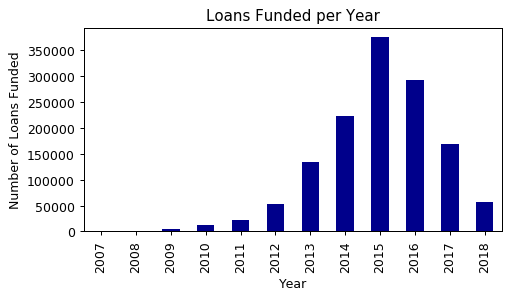

In [132]:
plt.figure(figsize=(6,3), dpi=90)
loans['issue_d'].dt.year.value_counts().sort_index().plot.bar(color='darkblue')
plt.xlabel('Year')
plt.ylabel('Number of Loans Funded')
plt.title('Loans Funded per Year')

We will form the test set from the most recent 20% of the loans

In [ ]:
loans_train = loans.loc[loans['issue_d'] <  loans['issue_d'].quantile(0.8)]
loans_test =  loans.loc[loans['issue_d'] >= loans['issue_d'].quantile(0.8)]

Check that we properly partitioned the loans:

In [134]:
print('Number of loans in the partition:   ', loans_train.shape[0] + loans_test.shape[0])
print('Number of loans in the full dataset:', loans.shape[0])

Number of loans in the partition:    1345310
Number of loans in the full dataset: 1345310


In [135]:
loans_test.shape[0] / loans.shape[0]

0.11111639696426846


The training set includes loans from June 2007 to June 2016. The test set includes loans from July 2016 to july 2018.
Now we need to delete the issue_d variable, because it was not available before the loan was funded.

In [136]:
loans_train.drop('issue_d', axis=1, inplace=True)
loans_test.drop('issue_d', axis=1, inplace=True)


Now separate the predictor variables from the response variable:

In [137]:
y_train = loans_train['charged_off']
y_test = loans_test['charged_off']

In [138]:
X_train = loans_train.drop('charged_off', axis=1)
X_test = loans_test.drop('charged_off', axis=1)

## 8. Linear Dependence of Charge-off on the Predictors

In [139]:
linear_dep = pd.DataFrame()

In [ ]:
for col in X_train.columns:
    linear_dep.loc[col, 'pearson_corr'] = X_train[col].corr(y_train)
linear_dep['abs_pearson_corr'] = abs(linear_dep['pearson_corr'])

In [ ]:
from sklearn.feature_selection import f_classif
for col in X_train.columns:
    mask = X_train[col].notnull()
    (linear_dep.loc[col, 'F'], linear_dep.loc[col, 'p_value']) = f_classif(pd.DataFrame(X_train.loc[mask, col]), y_train.loc[mask])

In [ ]:
linear_dep.sort_values('abs_pearson_corr', ascending=False, inplace=True)
linear_dep.drop('abs_pearson_corr', axis=1, inplace=True)

In [ ]:
linear_dep.reset_index(inplace=True)
linear_dep.rename(columns={'index':'variable'}, inplace=True)

In [ ]:
linear_dep.head(10)

In [ ]:
linear_dep.tail(10)

## 9. Model